Load libraries

In [1]:
import os
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomContrast
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import load_model
import json


/home/thesnakeguy/miniconda3/envs/tensorflow/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2025-10-24 22:39:48.660771: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-24 22:39:49.357426: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-24 22:39:52.924851: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You m

Load COCO annotations and generate masks

In [24]:
import os
import cv2
import numpy as np
from pycocotools.coco import COCO
from os.path import exists

# Define paths
data_root = "/mnt/c/Users/pdeschepper/Desktop/PERSONAL/DeepLearning/ImageSegmentation/Snakes_ImageSegmentation_keras/Bothriechis_segmentation_train_dataset/"
train_folder = os.path.join(data_root, "train")
train_annotations_path = os.path.join(train_folder, "_annotations.coco.json")

# Load COCO annotations
coco = COCO(train_annotations_path)

# Define class mapping
class_mapping = {
    "bothriechis": 1,
    "none": 0,
}

# Create directory for saving masks
os.makedirs(os.path.join(train_folder, "masks"), exist_ok=True)

# Generate masks for each image
for img_id in coco.imgs:
    img_info = coco.imgs[img_id]
    img_path = os.path.join(train_folder, img_info['file_name'])
    mask_path = os.path.join(train_folder, "masks", os.path.splitext(img_info['file_name'])[0] + ".png")  # Save masks as PNG

    if exists(mask_path):
        print(f"Mask already present for {img_id}")
    else:
        # Create a blank mask
        mask = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)

        # Get annotations for this image
        ann_ids = coco.getAnnIds(imgIds=img_info['id'])
        annotations = coco.loadAnns(ann_ids)

        # Fill the mask based on annotations
        for ann in annotations:
            class_name = coco.cats[ann['category_id']]['name']
            if class_name in class_mapping:
                class_index = class_mapping[class_name]
                for seg in ann['segmentation']:
                    polygon = np.array(seg).reshape(-1, 2).astype(np.int32)
                    cv2.fillPoly(mask, [polygon], class_index)

        # Save the mask
        cv2.imwrite(mask_path, mask)
        print(f"Mask was generated for {img_id}")

loading annotations into memory...
Done (t=0.09s)
creating index...
index created!
Mask was generated for 0
Mask was generated for 1
Mask was generated for 2
Mask was generated for 3
Mask was generated for 4
Mask was generated for 5
Mask was generated for 6
Mask was generated for 7
Mask was generated for 8
Mask was generated for 9
Mask was generated for 10
Mask was generated for 11
Mask was generated for 12
Mask was generated for 13
Mask was generated for 14
Mask was generated for 15
Mask was generated for 16
Mask was generated for 17
Mask was generated for 18
Mask was generated for 19
Mask was generated for 20
Mask was generated for 21
Mask was generated for 22
Mask was generated for 23
Mask was generated for 24
Mask was generated for 25
Mask was generated for 26
Mask was generated for 27
Mask was generated for 28
Mask was generated for 29
Mask was generated for 30
Mask was generated for 31
Mask was generated for 32
Mask was generated for 33
Mask was generated for 34
Mask was generate

In [25]:
def load_images_and_masks(image_dir, mask_dir, target_size=(128, 128)):
    image_paths = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir) if fname.endswith('.jpg')]
    mask_paths = [os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir) if fname.endswith('.png')]

    image_dataset = []
    mask_dataset = []

    for img_path, mask_path in zip(image_paths, mask_paths):
        # Load and preprocess image
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, target_size)
        image_dataset.append(image)

        # Load and preprocess mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)
        mask_dataset.append(mask)

    return np.array(image_dataset), np.array(mask_dataset)

# Load images and masks
image_dataset, mask_dataset = load_images_and_masks(
    train_folder,
    os.path.join(train_folder, "masks"),
    target_size=(512, 512)
)

print("Image dataset shape:", image_dataset.shape)
print("Mask dataset shape:", mask_dataset.shape)

Image dataset shape: (99, 512, 512, 3)
Mask dataset shape: (99, 512, 512)


Display random image with its mask

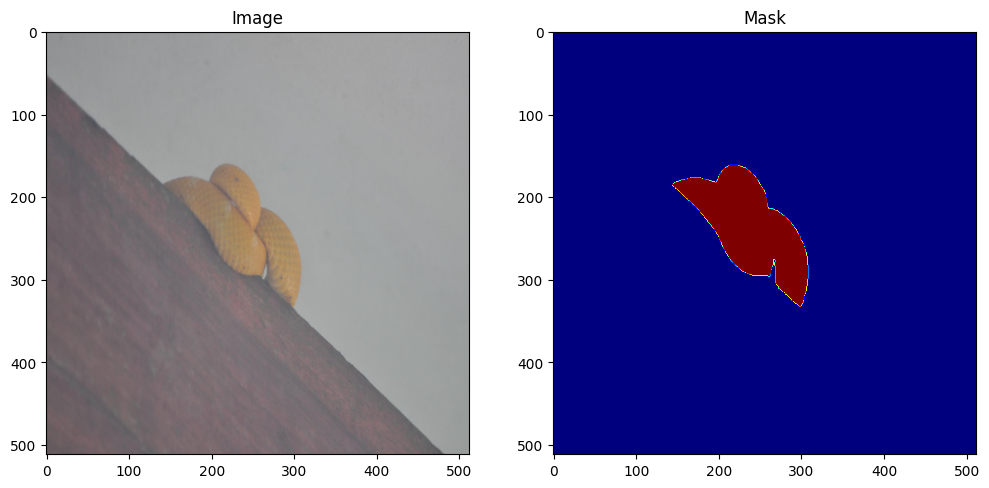

In [26]:
image_number = np.random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.title("Image")
plt.subplot(122)
plt.imshow(mask_dataset[image_number], cmap='jet')
plt.title("Mask")
plt.show()

Preprocessing

In [27]:
# Create 60, 20, 20 split for train, val, test
X_train, X_temp, y_train, y_temp = train_test_split(image_dataset, mask_dataset, test_size=0.6, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (39, 512, 512, 3)
y_train shape: (39, 512, 512)
X_val shape: (30, 512, 512, 3)
y_val shape: (30, 512, 512)
X_test shape: (30, 512, 512, 3)
y_test shape: (30, 512, 512)


Create tensorflow dataset objects

In [28]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(10).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(10).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(10).prefetch(tf.data.AUTOTUNE)

# Remap mask values in dataset to have 2 classes
def remap_masks(dataset):
    def map_func(images, masks):
        masks = tf.cast(masks, tf.int32)
        masks = tf.where(masks == 2, 1, masks)
        masks = tf.cast(masks, tf.uint8)  # Cast back to uint8 if needed
        return images, masks
    return dataset.map(map_func)

# Apply the remapping to your datasets
train_dataset = remap_masks(train_dataset)
val_dataset = remap_masks(val_dataset)
test_dataset = remap_masks(test_dataset)

W0000 00:00:1761339081.915704    1320 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Data augmentation

In [29]:
# Define augmentation
data_augmentation = tf.keras.Sequential([
    RandomRotation(factor=0.05, seed=42),
    RandomContrast(factor=0.05, seed=42)
])

def apply_augmentation(images, masks):
    # Normalize images to [0, 1] if not already
    images = tf.cast(images, tf.float32) / 255.0

    # Apply augmentation to images only
    augmented_images = data_augmentation(images, training=True)

    return augmented_images, masks

# Apply augmentation to the training dataset
train_dataset_aug = train_dataset.map(apply_augmentation, num_parallel_calls=tf.data.AUTOTUNE)


Verify datasets by visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.008554].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0203108].


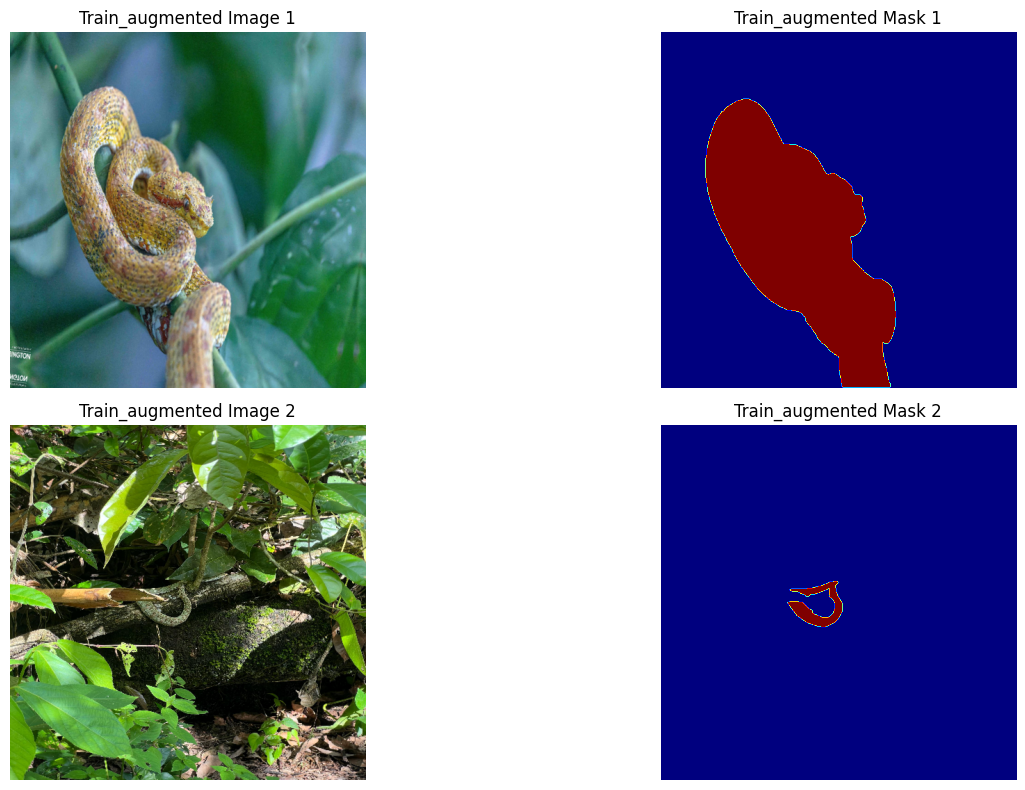

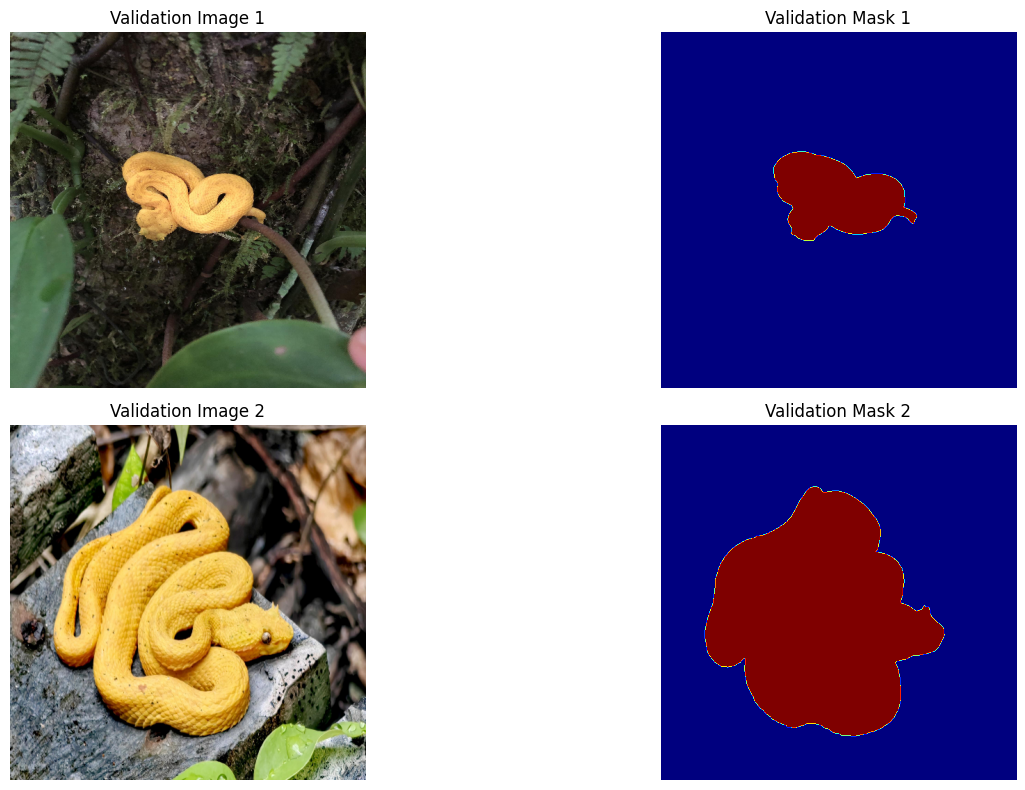

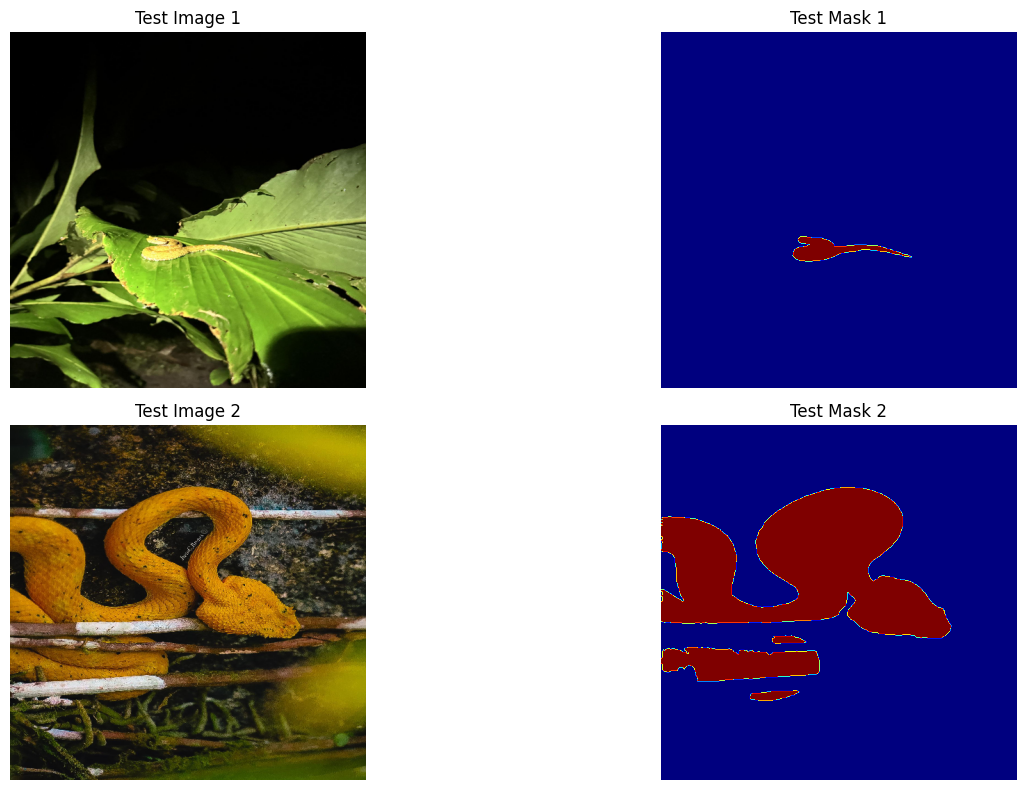

In [30]:
import matplotlib.pyplot as plt

def visualize_sample(dataset, title, num_samples=2):
    images, masks = next(iter(dataset))

    plt.figure(figsize=(16, 8))
    for i in range(min(num_samples, images.shape[0])):
        # Image
        plt.subplot(num_samples, 2, 2*i + 1)
        plt.imshow(images[i])
        plt.title(f"{title} Image {i+1}")
        plt.axis('off')

        # Mask
        plt.subplot(num_samples, 2, 2*i + 2)
        plt.imshow(masks[i], cmap='jet')
        plt.title(f"{title} Mask {i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize samples from each dataset
visualize_sample(train_dataset_aug, "Train_augmented")
visualize_sample(val_dataset, "Validation")
visualize_sample(test_dataset, "Test")


Build model: DeepLabV3+ with MobileNetV2 backbone

In [31]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Concatenate, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model

def build_unet_efficientnet(input_shape=(512, 512, 3), num_classes=2):
    # Load EfficientNetB0 as the backbone
    base_model = EfficientNetB0(input_shape=input_shape, include_top=False, weights='imagenet')

    # Freeze the base model
    base_model.trainable = False

    # Get the output of the backbone
    x = base_model.output

    # Skip connections from the encoder
    skip_connections = [
        base_model.get_layer('block2a_expand_activation').output,   
        base_model.get_layer('block3a_expand_activation').output,   
        base_model.get_layer('block4a_expand_activation').output,   
        base_model.get_layer('block5a_expand_activation').output,   
    ]

    # Upsample and concatenate with skip connections
    x = Conv2DTranspose(128, kernel_size=3, strides=2, padding='same', activation='relu', kernel_regularizer=l2(0.01))(x)  
    x = Concatenate()([x, skip_connections[3]])
    x = Conv2D(128, kernel_size=3, activation='relu', padding='same')(x)

    x = Conv2DTranspose(64, kernel_size=3, strides=2, padding='same', activation='relu', kernel_regularizer=l2(0.01))(x)   
    x = Concatenate()([x, skip_connections[2]])
    x = Conv2D(64, kernel_size=3, activation='relu', padding='same')(x)

    x = Conv2DTranspose(32, kernel_size=3, strides=2, padding='same', activation='relu', kernel_regularizer=l2(0.01))(x)  
    x = Concatenate()([x, skip_connections[1]])
    x = Conv2D(32, kernel_size=3, activation='relu', padding='same')(x)

    x = Conv2DTranspose(16, kernel_size=3, strides=2, padding='same', activation='relu', kernel_regularizer=l2(0.01))(x)   
    x = Concatenate()([x, skip_connections[0]])
    x = Conv2D(16, kernel_size=3, activation='relu', padding='same')(x)

    x = Conv2DTranspose(16, kernel_size=3, strides=2, padding='same', activation='relu', kernel_regularizer=l2(0.01))(x)  
    x = Conv2D(16, kernel_size=3, activation='relu', padding='same')(x)

    # Final output
    outputs = Conv2D(num_classes, kernel_size=1, activation='softmax', padding='same')(x)

    model = Model(inputs=base_model.input, outputs=outputs)
    return model

model = build_unet_efficientnet(input_shape=(512, 512, 3), num_classes=2)
model.summary()


Model: "functional_1"
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 512, 512,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 512, 512,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 512, 512,  │          0

Implement IoU metric

In [32]:
import tensorflow as tf
from tensorflow.keras import backend as K

def mean_iou(y_true, y_pred):
    # Convert softmax outputs to class indices
    y_pred = tf.argmax(y_pred, axis=-1)

    # Flatten the true and predicted labels
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    # Cast tensors to float32
    y_true_f = tf.cast(y_true_f, tf.float32)
    y_pred_f = tf.cast(y_pred_f, tf.float32)

    # Calculate confusion matrix
    intersection = tf.math.confusion_matrix(tf.cast(y_true_f, tf.int32), tf.cast(y_pred_f, tf.int32), num_classes=2, dtype=tf.float32)
    intersection_sum = tf.linalg.tensor_diag_part(intersection)
    union = tf.reduce_sum(intersection, axis=1) + tf.reduce_sum(intersection, axis=0) - intersection_sum

    # Calculate IoU for each class
    iou = intersection_sum / (union + tf.keras.backend.epsilon())

    # Return mean IoU
    return tf.reduce_mean(iou)


Implement Dice loss and combine it with SparseCategorialCrossEntropy

In [34]:
def dice_loss(y_true, y_pred, smooth=1e-6):
    """
    Computes Dice loss for sparse labels (integer-encoded masks).
    y_true: (B, H, W)
    y_pred: (B, H, W, num_classes)
    """
    # Convert sparse labels to one-hot
    num_classes = tf.shape(y_pred)[-1]
    y_true = tf.one_hot(tf.cast(y_true, tf.int32), num_classes)
    
    # Flatten
    y_true = tf.reshape(y_true, [-1, num_classes])
    y_pred = tf.reshape(y_pred, [-1, num_classes])
    
    # Compute intersection and union
    intersection = tf.reduce_sum(y_true * y_pred, axis=0)
    denominator = tf.reduce_sum(y_true + y_pred, axis=0)
    
    dice = (2. * intersection + smooth) / (denominator + smooth)
    dice_loss_value = 1 - tf.reduce_mean(dice)
    return dice_loss_value

def combined_loss(y_true, y_pred):
    sce_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    return 0.5 * dice_loss(y_true, y_pred) + 0.5 * sce_loss(y_true, y_pred)



Compile and Train the model

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy, Dice
from tensorflow.keras.callbacks import EarlyStopping

# STAGE 1: Frozen layers in pretrained model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=combined_loss,
    metrics=[mean_iou]
)

history_stage1 = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
    batch_size=6
)

# STAGE 2: Unfreeze top EfficientNet layers
for layer in model.layers[-20:]:
    layer.trainable = True

# Recompile with lower learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss=combined_loss,
    metrics=[mean_iou]
)

# Continue training
history_stage2 = model.fit(
    train_dataset,
    validation_data=val_dataset, 
    epochs=150,
    initial_epoch=100,
    batch_size=6
)

# Combine the histories
history = {
    'loss': history_stage1.history['loss'] + history_stage2.history['loss'],
    'val_loss': history_stage1.history['val_loss'] + history_stage2.history['val_loss'],
    'mean_iou': history_stage1.history['mean_iou'] + history_stage2.history['mean_iou'],
    'val_mean_iou': history_stage1.history['val_mean_iou'] + history_stage2.history['val_mean_iou']
}





Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 25s 5s/step - loss: 4.5717 - mean_iou: 0.3544 - val_loss: 4.3964 - val_mean_iou: 0.4136
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 4s/step - loss: 4.3488 - mean_iou: 0.4280 - val_loss: 4.2001 - val_mean_iou: 0.4419
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 17s 5s/step - loss: 4.1492 - mean_iou: 0.4540 - val_loss: 4.0259 - val_mean_iou: 0.4474
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 4s/step - loss: 3.9723 - mean_iou: 0.4583 - val_loss: 3.8746 - val_mean_iou: 0.4457
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 4s/step - loss: 3.8185 - mean_iou: 0.4572 - val_loss: 3.7410 - val_mean_iou: 0.4429
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 6s/step - loss: 3.6825 - mean_iou: 0.4558 - val_loss: 3.6149 - val_mean_iou: 0.4416
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step - loss: 3.5548 - mean_iou: 0.4552 - val_loss: 3.4908 - val_mean_iou: 0.4411
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step - loss: 3.4315 - mean_iou: 0.4551 - val_loss: 3.3693 - val_mean_iou: 0.4411


**Evaluate the model**

Evaluate on the test dataset: Loss and IoU

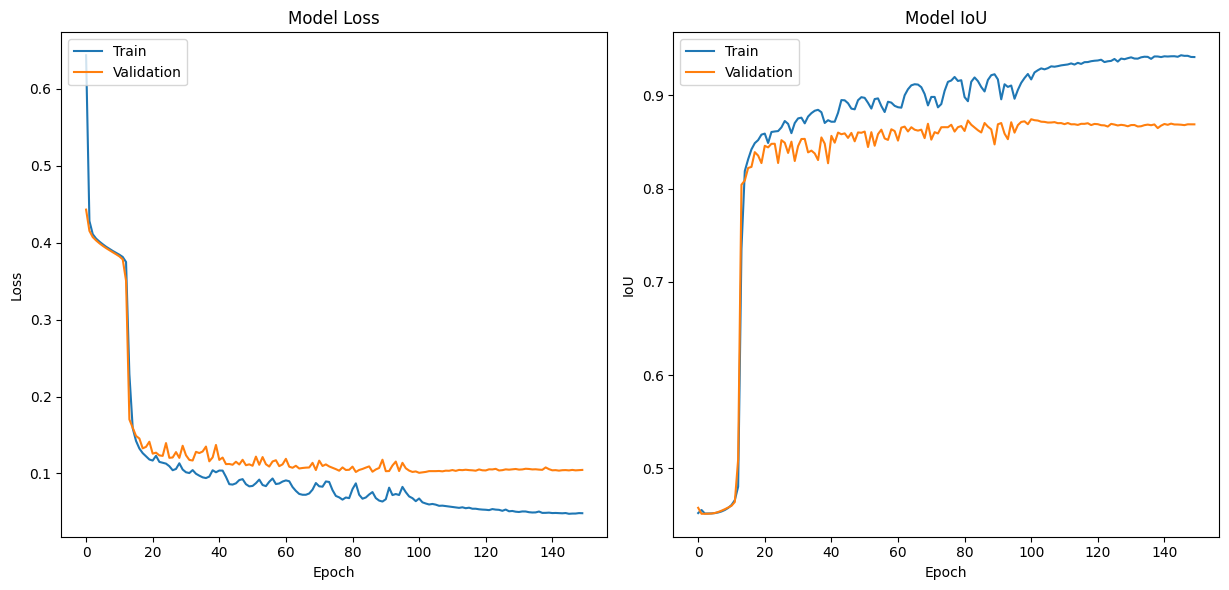

In [15]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    plt.figure(figsize=(18, 6))

    # Plot training & validation loss values
    plt.subplot(1, 3, 2)
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation IoU values
    plt.subplot(1, 3, 3)
    plt.plot(history['mean_iou'])
    plt.plot(history['val_mean_iou'])
    plt.title('Model IoU')
    plt.ylabel('IoU')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

plot_training_history(history)


In [16]:
print(history['val_mean_iou'])
print(history['loss'])

[0.45779111981391907, 0.4513736069202423, 0.4514032304286957, 0.45144736766815186, 0.4516489505767822, 0.4522169530391693, 0.4532991647720337, 0.4547024965286255, 0.4562823474407196, 0.4580749273300171, 0.45990774035453796, 0.4640175998210907, 0.5096614956855774, 0.8040336966514587, 0.8086288571357727, 0.8219854831695557, 0.8231954574584961, 0.8389599323272705, 0.8353020548820496, 0.8272478580474854, 0.8457586765289307, 0.8440728783607483, 0.8478689193725586, 0.8479561805725098, 0.8273412585258484, 0.8517857193946838, 0.8490273952484131, 0.8380999565124512, 0.8501980900764465, 0.829446017742157, 0.8454509377479553, 0.8530372977256775, 0.8531675934791565, 0.8387054800987244, 0.84060138463974, 0.837561309337616, 0.8304857611656189, 0.8547305464744568, 0.84811931848526, 0.8270730376243591, 0.8564131259918213, 0.8491141200065613, 0.859931230545044, 0.8581387996673584, 0.859088659286499, 0.8542537093162537, 0.8595871329307556, 0.8505713939666748, 0.8600990176200867, 0.8597335815429688, 0.86

Visualize predictions

2025-10-22 21:00:21.613778: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


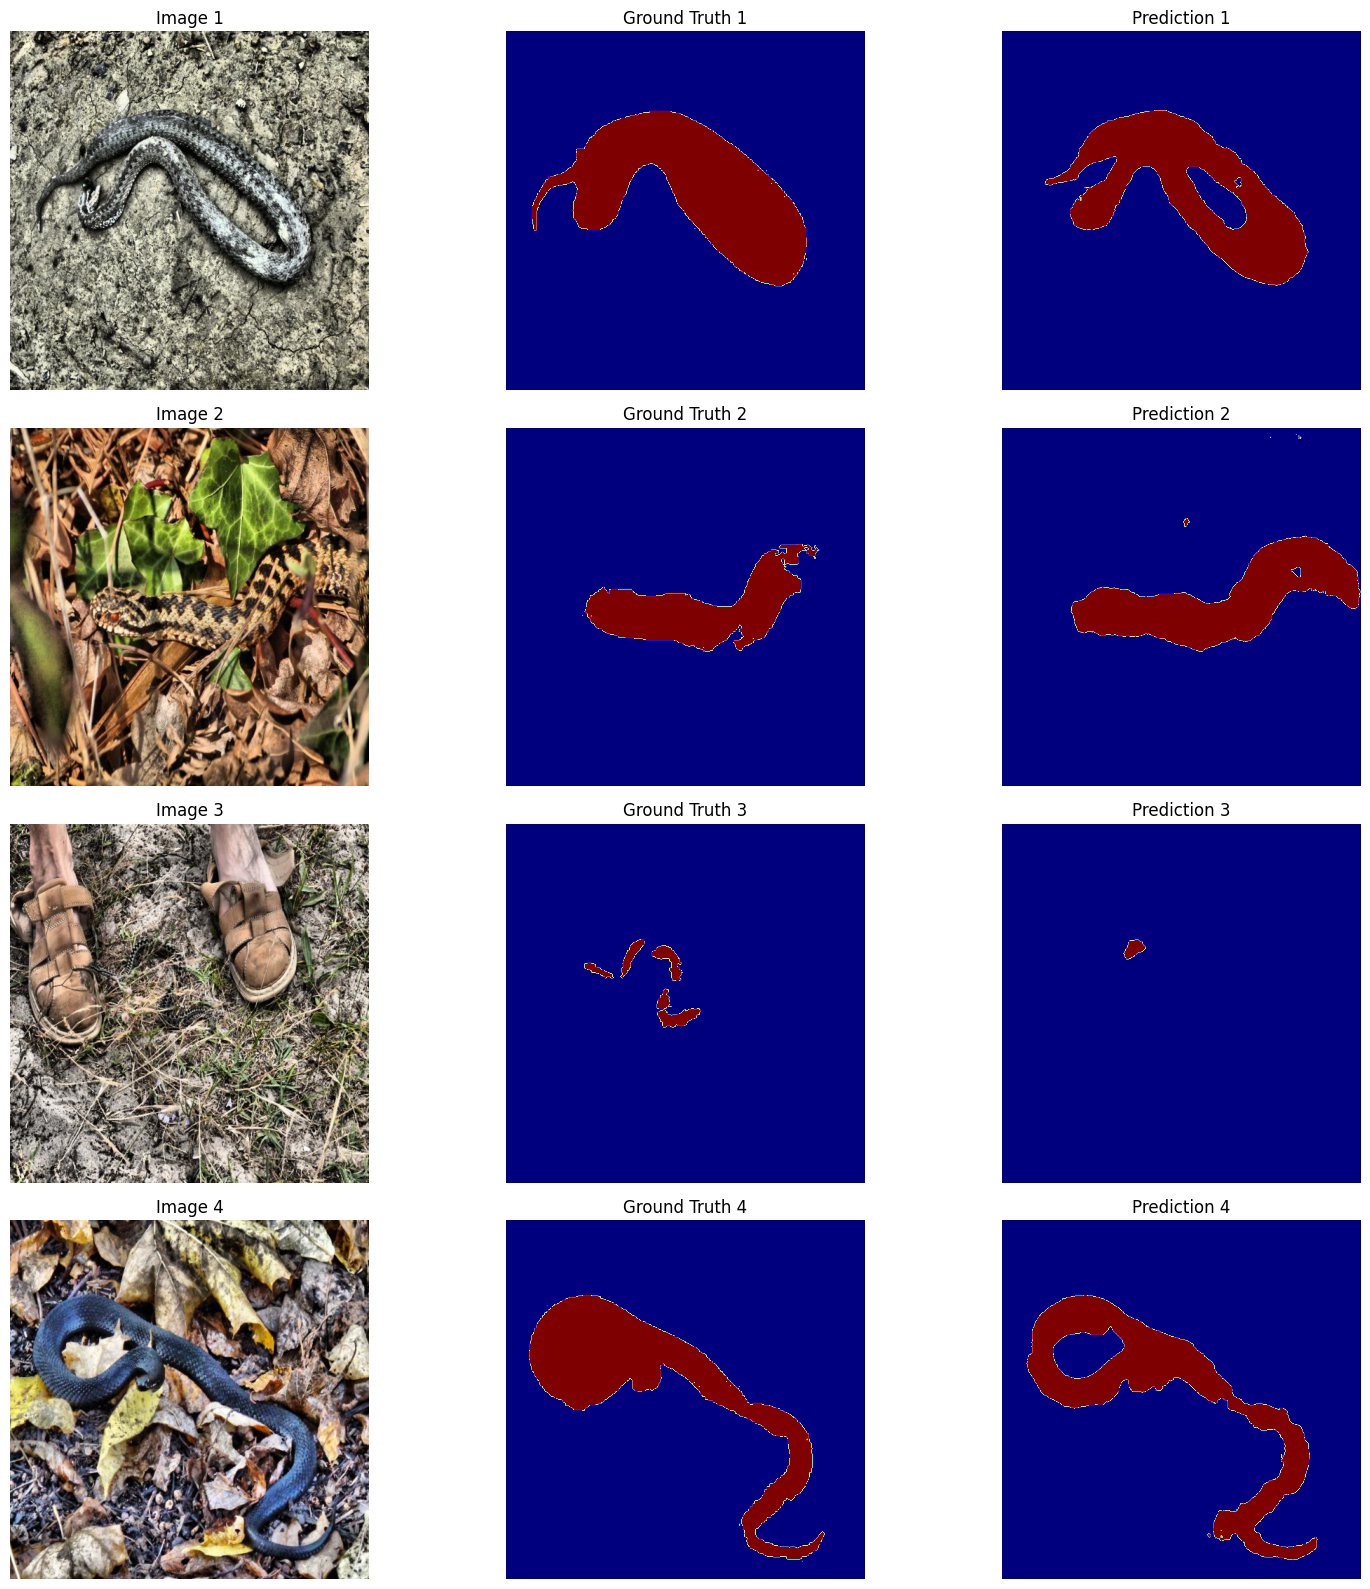

In [17]:
import matplotlib.pyplot as plt

def visualize_predictions(dataset, model, num_samples=4):
    """
    Randomly selects num_samples from the dataset, predicts, and visualizes.
    Works with batched or unbatched datasets.
    """
    # Unbatch so we can access individual examples
    all_data = list(dataset.unbatch().as_numpy_iterator())
    total_samples = len(all_data)

    # Randomly select indices
    random_indices = np.random.choice(total_samples, size=num_samples, replace=False)
    selected = [all_data[i] for i in random_indices]

    # Separate images and masks
    images = np.stack([img for img, _ in selected])
    masks = np.stack([mask for _, mask in selected])

    # Predict masks
    preds = model.predict(images)
    preds = tf.argmax(preds, axis=-1)

    # Plot
    plt.figure(figsize=(16, 4 * num_samples))
    for i in range(num_samples):
        # Original Image
        plt.subplot(num_samples, 3, 3*i + 1)
        plt.imshow(images[i])
        plt.title(f"Image {i+1}")
        plt.axis('off')

        # Ground Truth
        plt.subplot(num_samples, 3, 3*i + 2)
        plt.imshow(masks[i], cmap='jet')
        plt.title(f"Ground Truth {i+1}")
        plt.axis('off')

        # Prediction
        plt.subplot(num_samples, 3, 3*i + 3)
        plt.imshow(preds[i], cmap='jet')
        plt.title(f"Prediction {i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize predictions on the test dataset
visualize_predictions(test_dataset, model)


Save the mode and training history

In [22]:
model.save(os.path.join(data_root,"Vipera_SegmentationModel_V3_100+50epochs.keras"))
with open(os.path.join(data_root,"Vipera_SegmentationModel_V3_100+50epochs_traininghistory.json"), 'w') as f:
    json.dump(history, f)


Load the model

In [20]:
# Model path
data_root = "/mnt/c/Users/pdeschepper/Desktop/PERSONAL/DeepLearning/ImageSegmentation/Snakes_ImageSegmentation_keras/Vipera_segmentation_train_dataset/"
model_filename = "Vipera_SegmentationModel_V2_100+50epochs.keras"
model_path = os.path.join(data_root, model_filename)

# Import custom functions from the accessory script
sys.path.append("/mnt/c/Users/pdeschepper/Desktop/PERSONAL/DeepLearning/ImageSegmentation/Snakes_ImageSegmentation_keras/")
from HelperFuncs_IoU_DiceLoss_CombinedLoss import combined_loss, dice_loss, mean_iou

# Load model
model = load_model(
    model_path,
    custom_objects={
        'combined_loss': combined_loss,
        'dice_loss': dice_loss,
        'mean_iou': mean_iou
    } 
)

print("✅ Model loaded successfully!")
model.summary()

✅ Model loaded successfully!
Model: "functional_2"
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 512, 512,  │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 512, 512,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (

/home/thesnakeguy/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 30 variables whereas the saved optimizer has 58 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
